In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [21]:
#Aux Functions
def comb(n, r):
    return math.factorial(n) / (math.factorial(n-r) * math.factorial(r))

def scurve(x):
    return 1 / (1 + (x / (1 - x)) ** -3)

In [33]:
#Parameteric ranges
p = np.linspace(0.01, 0.99, 101)            #Initial frequency of defender allele
q = (1 - p)                                 #Frequency of non defenders
C = 100                                     #Number of eggs laid by non defender females
c = np.linspace(1, 100, 20, dtype = 'int')  #Cost to females who defend (lower c = higher cost)
a = np.linspace(1, 10, 5, dtype = 'int')    #Advantage for non defender mails in mating rate
u = np.round(np.linspace(0.1, 0.9, 5), 2)   #Probability female stays unmated
r = np.round(np.linspace(0.1, 0.9, 5), 2)   #Sex ration (Prob of male larvae in a mating)
DOMINANT = True                             #Switch between def allele being dominant or not

def s(d, using = 's'):                      #Probability of the group surviving based on the proportion of defenders in the larvae

    if using == 'linear':
        return d * (0.99 - 0.01) + 0.01
    elif using == 'expinv':
        return ((np.exp(-d) - np.exp(0))/(np.exp(-1) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 'exp':
        return ((np.exp(d) - np.exp(0))/(np.exp(1) - np.exp(0))) * (0.99 - 0.01) + 0.01
    elif using == 's':
        return 1/(1 + np.exp(-9.2 * (d - 0.5)))

In [23]:
#Parameter values
P = {
    'p' : np.linspace(0.01, 0.99, 101), #Initial frequency of defender allele
    'q' : (1 - p),                      #Frequency of non defenders
    'C' : 100,                          #Number of eggs laid by non defender females
    'c' : 90,                           #Cost to females who defend (lower c = higher cost)
    'a' : 2.5,                          #Advantage for non defender mails in mating rate
    'u' : 0.1,                          #Probability female stays unmated
    'r' : 0.2,                          #Sex ration (Prob of male larvae in a mating)
}

Text(0.5, 1.0, 'Shape of function s(d)')

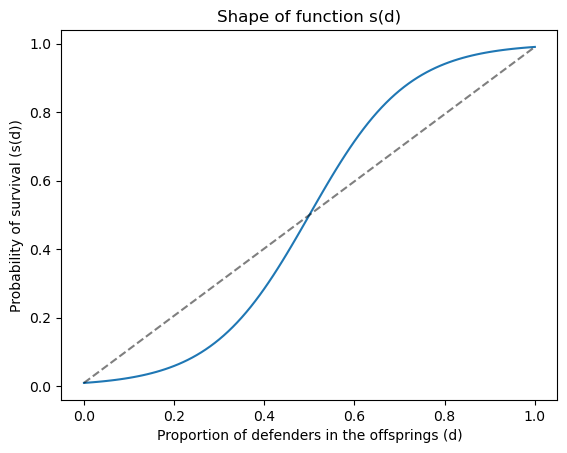

In [24]:
#The current shape of function s used for the simulations
d = np.linspace(0, 1, 101)
plt.plot(d, s(d))
plt.plot(d, np.linspace(0.01, 0.99, 101), 'k--', alpha = 0.5)
plt.xlabel('Proportion of defenders in the offsprings (d)')
plt.ylabel('Probability of survival (s(d))')
plt.title('Shape of function s(d)')

In [49]:
#Non matings
def f00(u, x00, C): #Results: M0 (1)
    if DOMINANT:
        return u * x00 * C * s(0)
    
    return u * x00 * C * s(0)

def f01(u, x01, C, c): #Results: M0 (0.5), M1 (0.5)
    S = 0
    if DOMINANT:
        for k in range(c+1):
            S += comb(c, k) * (((0.5)**(k))*((0.5)**(c-k))) * s(k/c)

        return u * x01 * c * S
    
    for k in range(C+1):
        S += comb(C, k) * (((0.5)**(k))*((0.5)**(C-k))) * s(k/C)

    return u * x01 * C * S

def f11(u, x11, c): #Results M1 (1)
    if DOMINANT:
        return u * x11 * c * s(1)
    
    return u * x11 * c * s(1)

#Matings
def f00m0(u, x00, y0, C): #Results: F00 (1-r), M0 (r)
    if DOMINANT:
        return (1-u) * x00 * C * s(0)
    
    return (1-u) * x00 * y0 * C * s(0)

def f11m1(u, x11, y1, c): #Results: F11 (1-r), M1 (r)
    if DOMINANT:
        return (1-u) * x11 * y1 * c * s(1)
    
    return (1-u) * x11 * y1 * c * s(1)

def f00m1(u, x00, y1, C, r): #Results: F01 (1-r), M0 (r)
    if DOMINANT:
        S = 0
        for k in range(C+1):
            S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * s((C-k)/C)

        return (1-u) * x00 * y1 * C * S
    
    return (1-u) * x00 * y1 * C * s(0)

def f11m0(u, x11, y0, c, r): #Results: F01 (1-r), M1(r)
    if DOMINANT:
        return (1-u) * x11 * y0 * c * s(1)
    
    S = 0
    for k in range(c+1):
        S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * s(k/c)

    return (1-u) * x11 * y0 * c * S

def f01m0(u, x01, y0, C, c, r): #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    if DOMINANT:
        for k in range(c+1):
            for m in range(k+1):
                for f in range(c-k+1):
                    S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * comb(k, m) * (2 ** -k) * comb(c-k, f) * (2 ** float(k-c)) * s((f+m)/c)

        return (1-u) * x01 * y0 * c * S
    
    
    for k in range(C+1):
        for m in range(k+1):
            for f in range(C-k+1):
                S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -k) * comb(C-k, f) * (2 ** (k-C)) * s(m/C)

    return (1-u) * x01 * y0 * C * S

def f01m1(u, x01, y1, C, c, r): #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    S = 0
    if DOMINANT:
        for k in range(c+1):
            for m in range(k+1):
                for f in range(c-k+1):
                    S += comb(c, k) * (((r)**(k))*((1-r)**(c-k))) * comb(k, m) * (2 ** -k) * comb(c-k, f) * (2 ** float(k-c)) * s(((c-k)+m)/c)

        return (1-u) * x01 * y1 * c * S
    
    for k in range(C+1):
        for m in range(k+1):
            for f in range(C-k+1):
                S += comb(C, k) * (((r)**(k))*((1-r)**(C-k))) * comb(k, m) * (2 ** -k) * comb(C-k, f) * (2 ** (k-C)) * s((f+m)/C)

    return (1-u) * x01 * y1 * C * S

In [50]:
#Next Generation
def nexgen(P):
    #Initial frequencies of all genotypes
    #Males
    x0 = P['q']
    x1 = P['p']

    y0 = P['a']*x0 / (P['a']*x0 + x1)
    y1 = x1 / (P['a']*x0 + x1)

    #Females (Assuming equilibrium values)
    x00 = P['q']*P['q']
    x01 = 2*P['p']*P['q']
    x11 = P['p']*P['p']

    #New generation
    #Males
    x0_n = f00(P['u'], x00, P['C']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f00m0(P['u'], x00, y0, P['C']) + f00m1(P['u'], x00, y1, P['C'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    x1_n = f11(P['u'], x11, P['c']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f11m1(P['u'], x11, y1, P['c']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    #Females
    x00_n = (1 - P['r']) * (f00m0(P['u'], x00, y0, P['C']) + (0.5) * f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']))

    x11_n = (1 - P['r']) * (f11m1(P['u'], x11, y1, P['c']) + (0.5) * f01m1(P['u'], x01, y1, P['C'], P['c'], P['r']))

    x01_n = (1 - P['r']) * (f00m1(P['u'], x00, y1, P['C'], P['r']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))
    

    #Calculating the number of each allele in new gen
    #Males
    n0_m = x0_n
    n1_m = x1_n

    #Females
    n0_f = 2*x00_n + x01_n
    n1_f = 2*x11_n + x01_n

    #Calculating ratios
    #Males
    p_m = n1_m/(n0_m+n1_m)
    q_m = n0_m/(n0_m+n1_m)

    #Females
    p_f = n1_f/(n0_f+n1_f)
    q_f = n0_f/(n0_f+n1_f)

    prop_ls = [p_m, q_m, p_f, q_f]

    #Creating a list for number of all organisms in next generation
    org_ls = [x0_n, x1_n, x00_n, x01_n, x11_n]
    sum_org = sum(org_ls)

    return prop_ls, org_ls

# Recessive Cases

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with alpha')

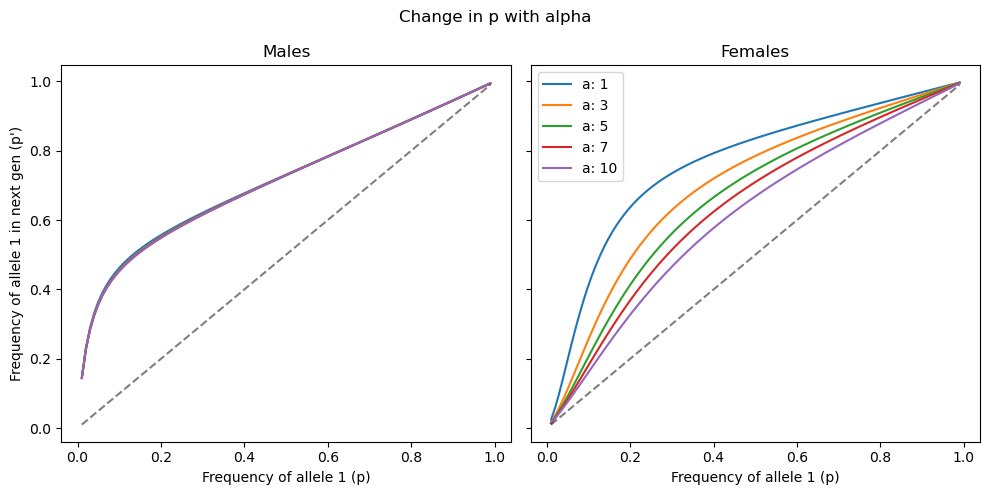

In [32]:
pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(a):
    param['a'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(a.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'a: ' + str(a[i]))
    ax[1].plot(p, pf_ls[i], label = 'a: ' + str(a[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with alpha')

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with sex ratio')

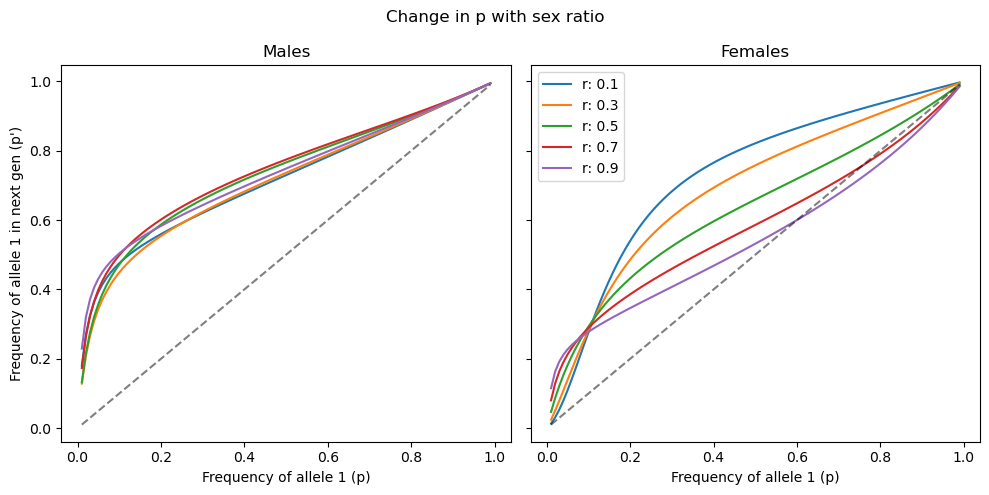

In [41]:
pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(r):
    param['r'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(r.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'r: ' + str(r[i]))
    ax[1].plot(p, pf_ls[i], label = 'r: ' + str(r[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with sex ratio')

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with c')

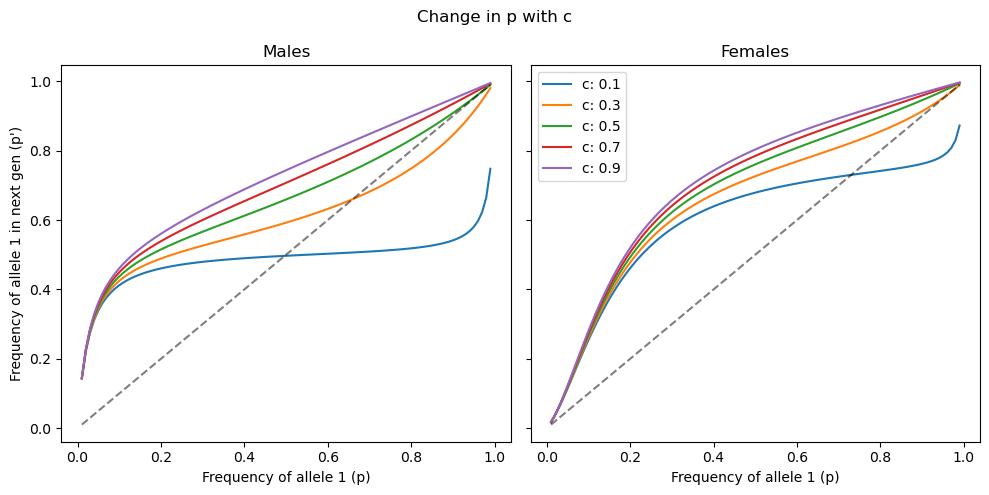

In [42]:
range_c = np.linspace(1, 100, 5, dtype = 'int')

pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(range_c):
    param['c'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(range_c.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'c: ' + str(r[i]))
    ax[1].plot(p, pf_ls[i], label = 'c: ' + str(r[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with c')

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with u')

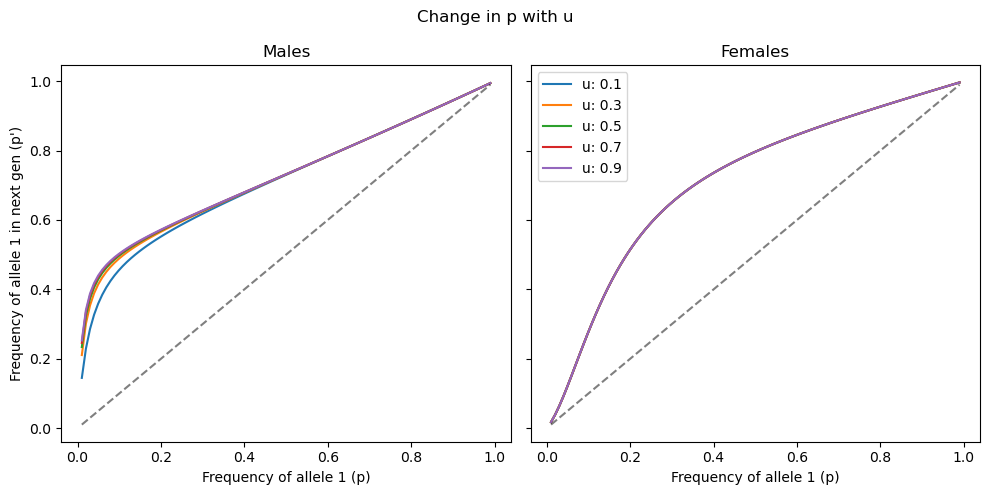

In [44]:
range_c = np.linspace(1, 100, 5, dtype = 'int')

pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(u):
    param['u'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(u.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'u: ' + str(u[i]))
    ax[1].plot(p, pf_ls[i], label = 'u: ' + str(u[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with u')

In [53]:
#New function for cont discreet generations
def congen(P, orgs = []):
    #Initial frequencies of all genotypes
    if len(orgs) == 0:
        #Males
        x0 = P['q']
        x1 = P['p']

        y0 = P['a']*x0 / (P['a']*x0 + x1)
        y1 = x1 / (P['a']*x0 + x1)

        #Females (Assuming equilibrium values)
        x00 = P['q']*P['q']
        x01 = 2*P['p']*P['q']
        x11 = P['p']*P['p']
    else:
        #Males
        x0 = orgs[0]
        x1 = orgs[1]

        y0 = P['a']*x0 / (P['a']*x0 + x1)
        y1 = x1 / (P['a']*x0 + x1)

        #Females (Assuming equilibrium values)
        x00 = orgs[2]
        x01 = orgs[3]
        x11 = orgs[4]

    #New generation
    #Males
    x0_n = f00(P['u'], x00, P['C']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f00m0(P['u'], x00, y0, P['C']) + f00m1(P['u'], x00, y1, P['C'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    x1_n = f11(P['u'], x11, P['c']) + (0.5) * f01(P['u'], x01, P['C'], P['c']) + P['r'] * (f11m1(P['u'], x11, y1, P['c']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))

    #Females
    x00_n = (1 - P['r']) * (f00m0(P['u'], x00, y0, P['C']) + (0.5) * f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']))

    x11_n = (1 - P['r']) * (f11m1(P['u'], x11, y1, P['c']) + (0.5) * f01m1(P['u'], x01, y1, P['C'], P['c'], P['r']))

    x01_n = (1 - P['r']) * (f00m1(P['u'], x00, y1, P['C'], P['r']) + f11m0(P['u'], x11, y0, P['c'], P['r']) + (0.5) * (f01m0(P['u'], x01, y0, P['C'], P['c'], P['r']) + f01m1(P['u'], x01, y1, P['C'], P['c'], P['r'])))
    

    #Calculating the number of each allele in new gen
    #Males
    n0_m = x0_n
    n1_m = x1_n

    #Females
    n0_f = 2*x00_n + x01_n
    n1_f = 2*x11_n + x01_n

    #Calculating ratios
    #Males
    p_m = n1_m/(n0_m+n1_m)
    q_m = n0_m/(n0_m+n1_m)

    #Females
    p_f = n1_f/(n0_f+n1_f)
    q_f = n0_f/(n0_f+n1_f)

    prop_ls = [p_m, q_m, p_f, q_f]

    #Creating a list for number of all organisms in next generation
    org_ls = [x0_n, x1_n, x00_n, x01_n, x11_n]
    sum_org = sum(org_ls)

    return prop_ls, org_ls

  0%|          | 0/25 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations')

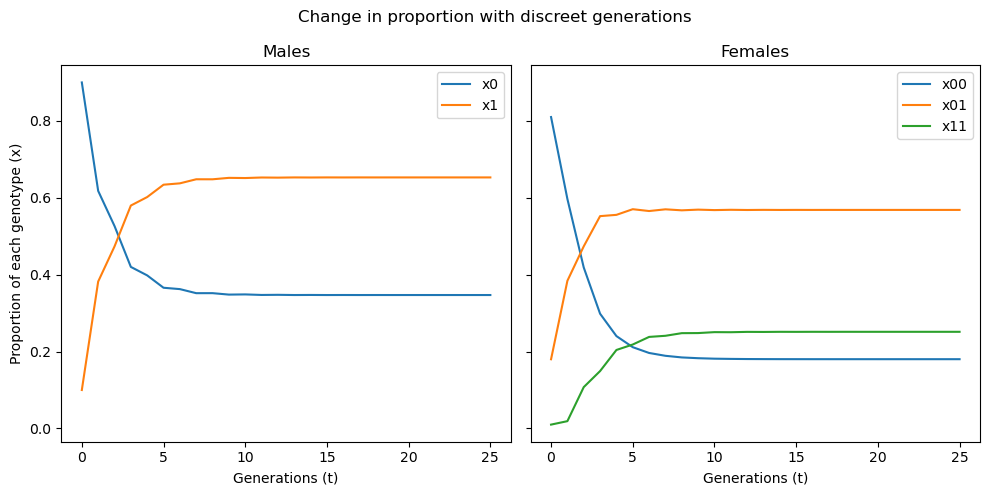

In [18]:
#Simulating proportions of each individual over a generation time
gentime = 25

param = P.copy()
param['p'] = 0.1
param['q'] = 0.9
param['c'] = 30
param['r'] = 0.5
param['u'] = 0.0
param['a'] = 10

orgs = []

ind_prop = {
    'x0':[param['q']],
    'x1':[param['p']],
    'x00':[param['q'] * param['q']],
    'x01':[2 * param['p'] * param['q']],
    'x11':[param['p'] * param['p']],
}

for t in tqdm(range(gentime)):
    prop_ls, org_ls = congen(param, orgs)

    ind_prop['x0'].append(org_ls[0] / (sum(org_ls[:2])))
    ind_prop['x1'].append(org_ls[1] / (sum(org_ls[:2])))
    ind_prop['x00'].append(org_ls[2] / (sum(org_ls[2:])))
    ind_prop['x01'].append(org_ls[3] / (sum(org_ls[2:])))
    ind_prop['x11'].append(org_ls[4] / (sum(org_ls[2:])))

    org_ls[:2] = org_ls[:2] / (sum(org_ls[:2]))
    org_ls[2:] = org_ls[2:] / (sum(org_ls[2:]))
    orgs = org_ls


fig, (ax0, ax1) = plt.subplots(ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x0'], label = 'x0')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x1'], label = 'x1')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x00'], label = 'x00')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x01'], label = 'x01')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x11'], label = 'x11')
ax1.legend()

ax0.set_title('Males')
ax1.set_title('Females')

ax0.set_xlabel('Generations (t)')
ax1.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion of each genotype (x)')

fig.suptitle('Change in proportion with discreet generations')

    

# Dominant Cases

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with alpha')

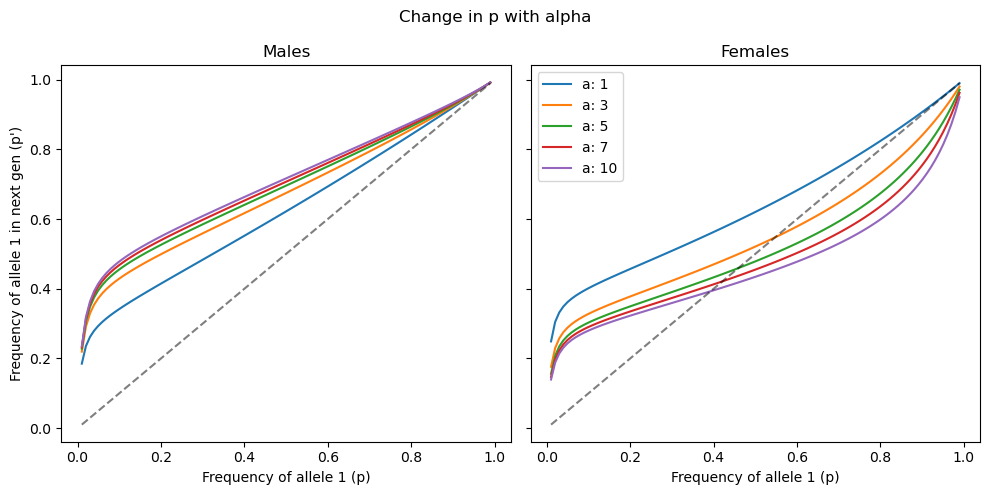

In [40]:
pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(a):
    param['a'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(a.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'a: ' + str(a[i]))
    ax[1].plot(p, pf_ls[i], label = 'a: ' + str(a[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with alpha')

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with sex ratio')

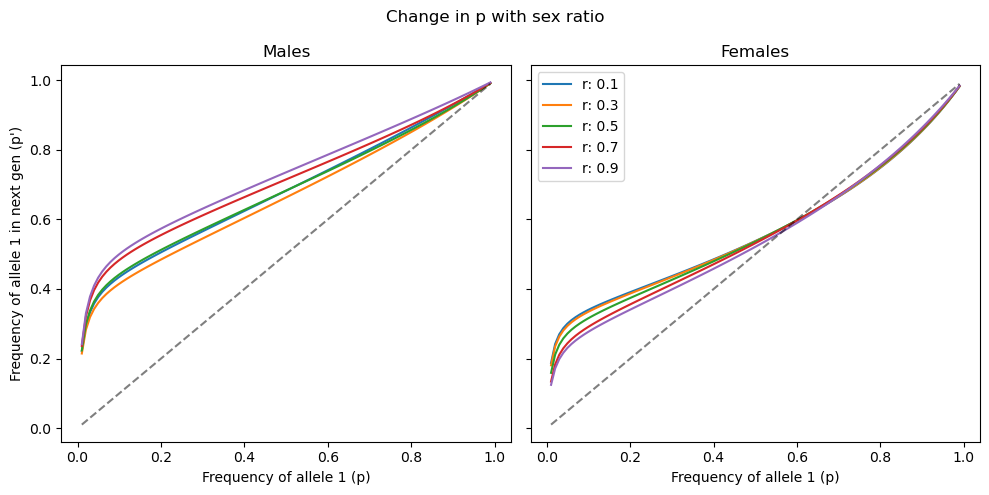

In [41]:
pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(r):
    param['r'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(r.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'r: ' + str(r[i]))
    ax[1].plot(p, pf_ls[i], label = 'r: ' + str(r[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with sex ratio')

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in p with c')

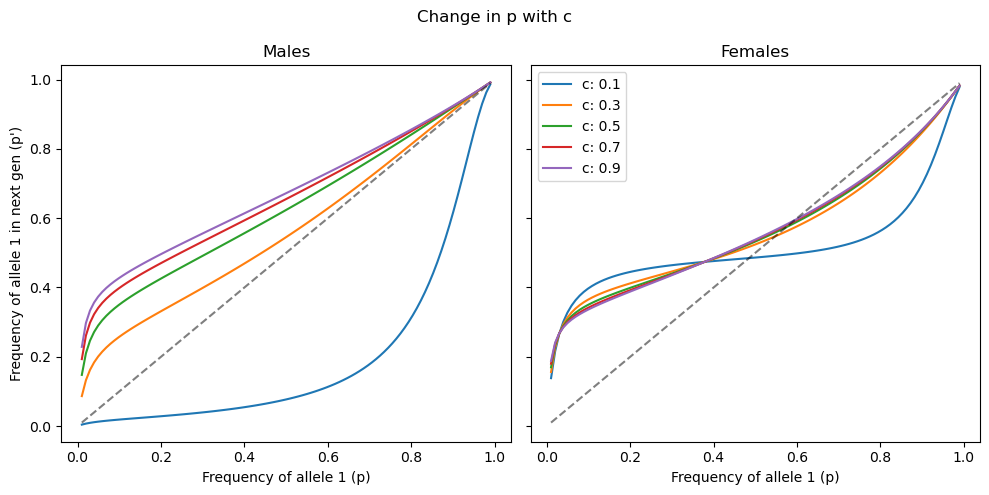

In [51]:
range_c = np.linspace(1, 100, 5, dtype = 'int')

pm_ls = []
qm_ls = []

pf_ls = []
qf_ls = []

param = P.copy()

#Iterating over a range of values for alpha
for i in tqdm(range_c):
    param['c'] = i

    prop_ls, org_ls = nexgen(param)

    pm_ls.append(prop_ls[0])
    qm_ls.append(prop_ls[1])

    pf_ls.append(prop_ls[2])
    qf_ls.append(prop_ls[3])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

for i in range(range_c.shape[0]):
    ax[0].plot(p, pm_ls[i], label = 'c: ' + str(r[i]))
    ax[1].plot(p, pf_ls[i], label = 'c: ' + str(r[i]))

ax[0].plot(p, p, 'k--', alpha=0.5)
ax[1].plot(p, p, 'k--', alpha=0.5)

ax[0].set_title('Males')
ax[1].set_title('Females')

plt.legend()
ax[1].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_xlabel("Frequency of allele 1 (p)")
ax[0].set_ylabel("Frequency of allele 1 in next gen (p')")
fig.suptitle('Change in p with c')

  0%|          | 0/25 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations')

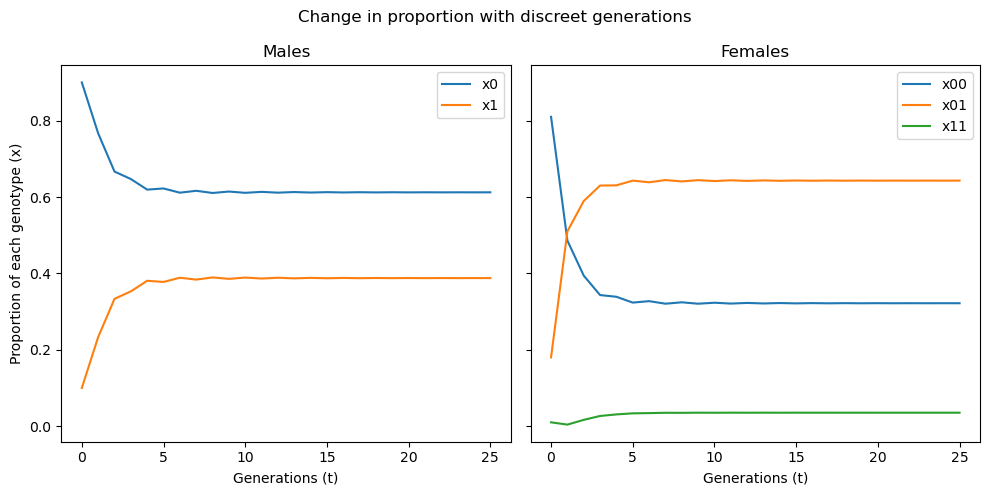

In [55]:
#Simulating proportions of each individual over a generation time
gentime = 25

param = P.copy()
param['p'] = 0.1
param['q'] = 0.9
param['c'] = 10
param['r'] = 0.3
param['u'] = 0.1
param['a'] = 10

orgs = []

ind_prop = {
    'x0':[param['q']],
    'x1':[param['p']],
    'x00':[param['q'] * param['q']],
    'x01':[2 * param['p'] * param['q']],
    'x11':[param['p'] * param['p']],
}

for t in tqdm(range(gentime)):
    prop_ls, org_ls = congen(param, orgs)

    ind_prop['x0'].append(org_ls[0] / (sum(org_ls[:2])))
    ind_prop['x1'].append(org_ls[1] / (sum(org_ls[:2])))
    ind_prop['x00'].append(org_ls[2] / (sum(org_ls[2:])))
    ind_prop['x01'].append(org_ls[3] / (sum(org_ls[2:])))
    ind_prop['x11'].append(org_ls[4] / (sum(org_ls[2:])))

    org_ls[:2] = org_ls[:2] / (sum(org_ls[:2]))
    org_ls[2:] = org_ls[2:] / (sum(org_ls[2:]))
    orgs = org_ls


fig, (ax0, ax1) = plt.subplots(ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x0'], label = 'x0')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x1'], label = 'x1')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x00'], label = 'x00')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x01'], label = 'x01')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x11'], label = 'x11')
ax1.legend()

ax0.set_title('Males')
ax1.set_title('Females')

ax0.set_xlabel('Generations (t)')
ax1.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion of each genotype (x)')

fig.suptitle('Change in proportion with discreet generations')

  0%|          | 0/25 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Change in proportion with discreet generations')

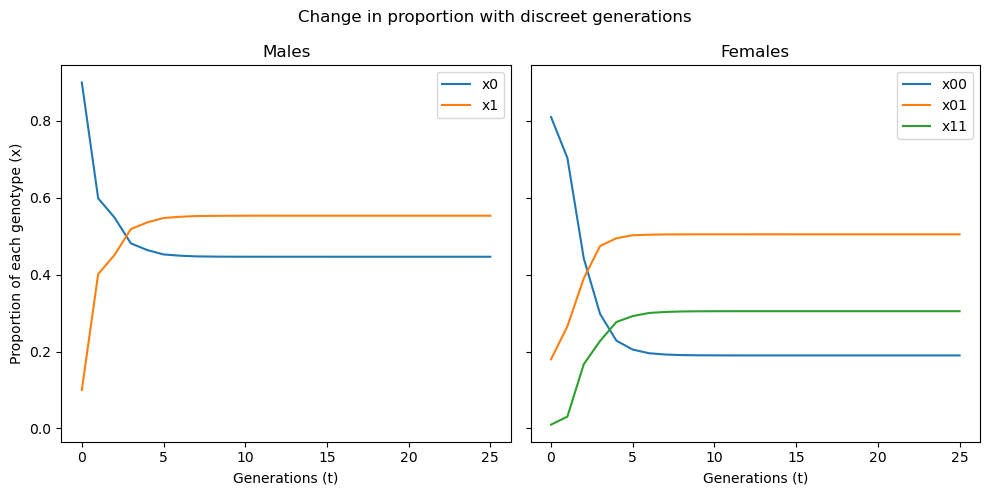

In [56]:
DOMINANT = False
#Simulating proportions of each individual over a generation time
gentime = 25

param = P.copy()
param['p'] = 0.1
param['q'] = 0.9
param['c'] = 10
param['r'] = 0.3
param['u'] = 0.1
param['a'] = 10

orgs = []

ind_prop = {
    'x0':[param['q']],
    'x1':[param['p']],
    'x00':[param['q'] * param['q']],
    'x01':[2 * param['p'] * param['q']],
    'x11':[param['p'] * param['p']],
}

for t in tqdm(range(gentime)):
    prop_ls, org_ls = congen(param, orgs)

    ind_prop['x0'].append(org_ls[0] / (sum(org_ls[:2])))
    ind_prop['x1'].append(org_ls[1] / (sum(org_ls[:2])))
    ind_prop['x00'].append(org_ls[2] / (sum(org_ls[2:])))
    ind_prop['x01'].append(org_ls[3] / (sum(org_ls[2:])))
    ind_prop['x11'].append(org_ls[4] / (sum(org_ls[2:])))

    org_ls[:2] = org_ls[:2] / (sum(org_ls[:2]))
    org_ls[2:] = org_ls[2:] / (sum(org_ls[2:]))
    orgs = org_ls


fig, (ax0, ax1) = plt.subplots(ncols = 2, sharey = True, layout = 'tight', figsize = (10, 5))

ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x0'], label = 'x0')
ax0.plot(np.arange(0, gentime + 1, 1), ind_prop['x1'], label = 'x1')
ax0.legend()

ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x00'], label = 'x00')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x01'], label = 'x01')
ax1.plot(np.arange(0, gentime + 1, 1), ind_prop['x11'], label = 'x11')
ax1.legend()

ax0.set_title('Males')
ax1.set_title('Females')

ax0.set_xlabel('Generations (t)')
ax1.set_xlabel('Generations (t)')

ax0.set_ylabel('Proportion of each genotype (x)')

fig.suptitle('Change in proportion with discreet generations')